# Atividade 8 - Classificador MLP

# Dataset Completo - Não Normalizado

# Algoritmo MLPClassifier

● Seguir o mesmo padrão das atividades 6 e 7, mas agora para redes MLP

● Realizar validação cruzada para testar redes neurais (mesmos subconjuntos utilizados em SVMs)
utilizando:

    - todas a características
    - apenas com os componentes principais
    - apenas com as características selecionadas pelo selecionador 1
    - apenas com as características selecionadas pelo selecionador 2 (opcional)
    
Em cada um, calibrar os parâmetros (número de neurônios da camada oculta (ex: 10, raiz quadrada
do nr de características, um nr maior), taxa de aprendizado (ex: 0,1; 0,01), função de ativação
(sigmoide na camada de saída, mas na camada oculta testar tangente hiperbólica e leaky relu (ou
relu)) e reportar os valores médios de precisão, revocação e acurácia para o que apresentou
melhor acurácia (com os respectivos intervalos de confiança)

## Dataset Completo

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math


from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.neural_network import MLPClassifier


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st


import warnings

warnings.filterwarnings("ignore")

random_state=5007

%matplotlib inline

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


## Pré-Processamento

In [3]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [4]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [5]:
continuous_feat = ['Age',
                   'Number of sexual partners',
                   'First sexual intercourse',
                   'Num of pregnancies', 
                   'Smokes (years)',
                   'Smokes (packs/year)',
                   'Hormonal Contraceptives (years)',
                   'IUD (years)',
                   'STDs (number)',
                   'STDs: Number of diagnosis',
                   'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

binary_feat = [  'Smokes',
                 'Hormonal Contraceptives',
                 'IUD',
                 'STDs',
                 'STDs:condylomatosis',
                 'STDs:cervical condylomatosis',
                 'STDs:vaginal condylomatosis',
                 'STDs:vulvo-perineal condylomatosis',
                 'STDs:syphilis',
                 'STDs:pelvic inflammatory disease',
                 'STDs:genital herpes',
                 'STDs:molluscum contagiosum',
                 'STDs:AIDS',
                 'STDs:HIV',
                 'STDs:Hepatitis B',
                 'STDs:HPV',
                 'Dx:Cancer',
                 'Dx:CIN',
                 'Dx:HPV',
                 'Dx',
                 'Hinselmann',
                 'Schiller',
                 'Citology']                               


In [6]:
df_imp = df_processed.copy()

In [7]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()


## Stratified Cross- Validation

### Dataset Desbalanceado

In [8]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
        
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    n_Neurons_range = grid_params.get('n_Neurons_range')
    n_layers_range = grid_params.get('n_layers_range')
    learning_rate_init_range = grid_params.get('learning_rate_init_range')
    f_Activation = grid_params.get('f_Activation')
    momentum_range = grid_params.get('momentum_range')
    max_iter = grid_params.get('max_iter')
    early_stopping = grid_params.get('early_stopping')       
    
    # Testa varias funções de ativação
    for func in f_Activation:
        print("-> Teste função {}".format(func))
        
        # Testa para 1 a n layers
        for layers in list(np.arange(n_layers_range[0], n_layers_range[1]+1, 1)):
            
            # Calcula o numero de possiveis configuracoes de MLP (n de layers e neuronios por layers)
            n_possibilidades = pow(len(n_Neurons_range),layers)

            # Monta uma tuple com a configuracao atual
            for i in range (n_possibilidades):
                config = tuple()
                encoded = i
                for j in range (layers):
                    new_neuron = math.floor(encoded / pow(len(n_Neurons_range),(layers - j - 1)))

                    config = config + (n_Neurons_range[new_neuron], )
                    encoded = encoded % math.pow(len(n_Neurons_range),(layers - j - 1))

                # Testa varios learning_rate
                for learning_rate_i in learning_rate_init_range:

                    # Testa vários momentums para o sgd
                    for momentum in momentum_range:
                    
                        # Testa vários valores maximos de iteracao
                        for iters in max_iter:
                        
                            # Testa com e sem early stop
                            for stop in early_stopping:
                                
                                print('-> Modelo: func ={} | params {} | learning_rate={:.3f} | momentum = {:.2f} | max_iter = {} | early_stopping = {}'.format(
                                    func, config, learning_rate_i, momentum,iters, stop))
                                clf = algoritmo(activation=func, hidden_layer_sizes=config, learning_rate_init=learning_rate_i, 
                                                solver = 'sgd', momentum = momentum,max_iter = iters,early_stopping = stop,
                                                verbose=0, random_state = random_state)

                                # Folds
                                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                                    fold_number = fold
                                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                                    # quantidade de classes dentro da fold
                                    #REMOVED

                                    # aplica o classificador
                                    clf = clf.fit(X_train, y_train)

                                    # predict no dataset de treino 
                                    y_train_preds = clf.predict(X_train)
                                    # predict no dataset de teste
                                    y_pred = clf.predict(X_test)


                                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                                    recall = recall_score(y_test, y_pred)
                                    accuracy = accuracy_score(y_test, y_pred)
                                    precision = precision_score(y_test, y_pred)
                                    scores.append([config, learning_rate_i, func, momentum, iters, stop,
                                                   clf.n_iter_, fold_number, precision, recall, accuracy])



    return np.array(scores)

### Dataset Balanceado

In [9]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    n_Neurons_range = grid_params.get('n_Neurons_range')
    n_layers_range = grid_params.get('n_layers_range')
    learning_rate_init_range = grid_params.get('learning_rate_init_range')
    f_Activation = grid_params.get('f_Activation')
    momentum_range = grid_params.get('momentum_range')
    max_iter = grid_params.get('max_iter')
    early_stopping = grid_params.get('early_stopping')   
    
    
    # Testa varias funções de ativação
    for func in f_Activation:
        print("-> Teste função {}".format(func))
        
        # Testa para 1 a n layers
        for layers in list(np.arange(n_layers_range[0], n_layers_range[1]+1, 1)):
            
            # Calcula o numero de possiveis configuracoes de MLP (n de layers e neuronios por layers)
            n_possibilidades = pow(len(n_Neurons_range),layers)

            # Monta uma tuple com a configuracao atual
            for i in range (n_possibilidades):
                config = tuple()
                encoded = i
                for j in range (layers):
                    new_neuron = math.floor(encoded / pow(len(n_Neurons_range),(layers - j - 1)))

                    config = config + (n_Neurons_range[new_neuron], )
                    encoded = encoded % math.pow(len(n_Neurons_range),(layers - j - 1))
                    
                # Testa varios learning_rate
                for learning_rate_i in learning_rate_init_range:

                    # Testa vários momentums para o sgd
                    for momentum in momentum_range:
                    
                        # Testa vários valores maximos de iteracao
                        for iters in max_iter:
                        
                            # Testa com e sem early stop
                            for stop in early_stopping:
                                
                                print('-> Modelo: func ={} | params {} | learning_rate={:.3f} | momentum = {:.2f} | max_iter = {} | early_stopping = {}'.format(
                                    func, config, learning_rate_i, momentum,iters, stop))
                                clf = algoritmo(activation=func, hidden_layer_sizes=config, learning_rate_init=learning_rate_i, 
                                                solver = 'sgd', momentum = momentum,max_iter = iters,early_stopping = stop,
                                                verbose=0, random_state = random_state)

                                # Folds
                                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                                    fold_number = fold
                                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                                    # Normaliza MinMax para aplicar Smote
                                    X_train_normalized = minmax_scale.fit_transform(X_train)
                                    X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())

                                    # SMOTETomek (apenas os dados de treino)
                #                    print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                                    X_train, y_train = cc.fit_resample(X_train_normalized, y_train)

                                    # Retorna para valores não normalizados
                                    X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
                #                    print folds balanceados
                                    #REMOVED

                                    # quantidade de classes dentro da fold
                                    #REMOVED

                                    # aplica o classificador
                                    clf = clf.fit(X_train, y_train)

                                    # predict no dataset de treino 
                                    y_train_preds = clf.predict(X_train)
                                    # predict no dataset de teste
                                    y_pred = clf.predict(X_test)


                                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                                    recall = recall_score(y_test, y_pred)
                                    accuracy = accuracy_score(y_test, y_pred)
                                    precision = precision_score(y_test, y_pred)
                                    scores.append([config, learning_rate_i, func, momentum, iters, stop,
                                                   clf.n_iter_, fold_number, precision, recall, accuracy])


    return np.array(scores)

## Grid de Parametros para teste

In [10]:
grid_params_all = {'n_Neurons_range': [5,7,10,15,20],
                   'n_layers_range' : [1,2],
               'learning_rate_init_range': [0.001, 0.01, 0.1],
               'f_Activation': ['logistic', 'tanh', 'relu'],
                'momentum_range': [0.3, 0.6,  0.9],
                'max_iter':[300],
                'early_stopping':[True,False]
              }

## Calculando Precisão, Revocação e Acurácia

### Algortimo-> MLPClassifier

### Dataset Desbalanceado

In [11]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_imp, k, MLPClassifier, random_state, grid_params_all, 
                                                   shuffle=False, shrinking=True))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'Configuration', 1: 'learning_rate_init', 2: 'f_Activation',
                                                        3:'Momentum', 4:'Max_iters', 5:'Early_stop', 6:'n_iters',
                                                        7:'Fold', 8: 'Precision', 9: 'Recall', 10: 'Accuracy'}) 
scores_unbalanced['Algorimto'] = 'MLPClassifier'
float_cols = ['learning_rate_init', 'Momentum', 'Max_iters', 'n_iters', 'Fold', 'Precision', 'Recall', 'Accuracy']
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste função logistic
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.30 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.30 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.60 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.60 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.90 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.90 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.010

In [12]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-Dataset_Completo_Não_Normalizado_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

,Configuration,learning_rate_init,f_Activation,Momentum,Max_iters,Early_stop,n_iters,Fold,Precision,Recall,Accuracy,Algorimto
0,"(5,)",0.001,logistic,0.3,300,True,14,1,0.285714,0.4,0.906977,MLPClassifier
1,"(5,)",0.001,logistic,0.3,300,True,14,2,0.400000,0.4,0.930233,MLPClassifier
2,"(5,)",0.001,logistic,0.3,300,True,14,3,0.000000,0.0,0.895349,MLPClassifier
3,"(5,)",0.001,logistic,0.3,300,True,15,4,0.000000,0.0,0.906977,MLPClassifier
4,"(5,)",0.001,logistic,0.3,300,True,15,5,0.000000,0.0,0.883721,MLPClassifier


### Dataset Balanceado

In [13]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_imp, k, MLPClassifier, random_state, grid_params_all, 
                                                   shuffle=False, shrinking=True))
scores_balanced = scores_balanced.rename(columns = {0: 'Configuration', 1: 'learning_rate_init', 2: 'f_Activation',
                                                        3:'Momentum', 4:'Max_iters', 5:'Early_stop', 6:'n_iters',
                                                        7:'Fold', 8: 'Precision', 9: 'Recall', 10: 'Accuracy'}) 
scores_balanced['Algorimto'] = 'MLPClassifier'
float_cols = ['learning_rate_init', 'Momentum', 'Max_iters', 'n_iters', 'Fold', 'Precision', 'Recall', 'Accuracy']
scores_balanced[float_cols] = scores_balanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
------
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste função logistic
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.30 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.30 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.60 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.60 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.90 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.90 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | lea

In [14]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-Dataset_Completo_Não_Normalizado_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

,Configuration,learning_rate_init,f_Activation,Momentum,Max_iters,Early_stop,n_iters,Fold,Precision,Recall,Accuracy,Algorimto
0,"(5,)",0.001,logistic,0.3,300,True,19,1,0.285714,0.400000,0.906977,MLPClassifier
1,"(5,)",0.001,logistic,0.3,300,True,12,2,0.333333,0.400000,0.918605,MLPClassifier
2,"(5,)",0.001,logistic,0.3,300,True,12,3,0.000000,0.000000,0.860465,MLPClassifier
3,"(5,)",0.001,logistic,0.3,300,True,12,4,0.400000,0.333333,0.918605,MLPClassifier
4,"(5,)",0.001,logistic,0.3,300,True,12,5,0.000000,0.000000,0.883721,MLPClassifier


## Calculando os parâmetros com maior acurácia

### Dataset Desbalanceado

In [15]:
mean_unbalanced = scores_unbalanced.groupby(['Configuration', 'learning_rate_init', 'f_Activation',
                                             'Momentum', 'Max_iters', 'Early_stop']).mean().drop('Fold', axis = 1)
mean_unbalanced

n_iters  Precision    Recall  Accuracy
Configuration learning_rate_init f_Activation Momentum Max_iters Early_stop                                        
(5,)          0.001              logistic     0.3      300       False         300.0   0.000000  0.000000  0.935910
                                                                 True           14.4   0.108571  0.120000  0.898564
                                              0.6      300       False         300.0   0.000000  0.000000  0.935910
                                                                 True           13.5   0.108571  0.120000  0.904391
                                              0.9      300       False         144.4   0.000000  0.000000  0.935910
                                                                 True           13.0   0.083333  0.060000  0.898577
                                 relu         0.3      300       False         180.7   0.000000  0.000000  0.931259
                                                                 True           12.3   0.088889  0.100000  0.910274
                                              0.6      300       False         169.0   0.000000  0.000000  0.931259
                                                                 True           12.0   0.055556  0.080000  0.910260
                                              0.9      300       False         300.0   0.000000  0.000000  0.933584
                                                                 True           12.9   0.062222  0.080000  0.914911
                                 tanh         0.3      300       False         263.7   0.000000  0.000000  0.931259
                                                                 True           12.0   0.050000  0.040000  0.924241
                                              0.6      300       False         211.7   0.000000  0.000000  0.932421
                                                                 True           12.0   0.050000  0.040000  0.924241
                                              0.9      300       False         100.8   0.000000  0.000000  0.933584
                                                                 True           12.0   0.050000  0.040000  0.925417
              0.010              logistic     0.3      300       False         116.9   0.000000  0.000000  0.935910
                                                                 True           12.2   0.083333  0.060000  0.916088
                                              0.6      300       False          80.8   0.000000  0.000000  0.935910
                                                                 True           12.2   0.066667  0.040000  0.926594
                                              0.9      300       False          27.0   0.000000  0.000000  0.935910
                                                                 True           12.0   0.100000  0.020000  0.930082
                                 relu         0.3      300       False         300.0   0.000000  0.000000  0.934747
                                                                 True           12.7   0.086667  0.060000  0.925417
                                              0.6      300       False         300.0   0.100000  0.020000  0.937086
                                                                 True           12.5   0.100000  0.020000  0.927756
                                              0.9      300       False         134.7   0.583333  0.420000  0.949877
                                                                 True           12.0   0.100000  0.020000  0.928919
                                 tanh         0.3      300       False          92.0   0.000000  0.000000  0.933584
                                                                 True           12.0   0.066667  0.040000  0.928933
                                              0.6      300       False          65.9   0.000000  0.000000  0.934747
                 

In [16]:
# Top 5 com maior média
display(mean_unbalanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

,,,,,,n_iters,Precision,Recall,Accuracy
Configuration,learning_rate_init,f_Activation,Momentum,Max_iters,Early_stop,,,,
"(5, 7)",0.01,relu,0.9,300,False,244.3,0.692619,0.596667,0.955705
"(20, 5)",0.01,relu,0.9,300,False,138.1,0.559167,0.443333,0.951081
"(20,)",0.01,tanh,0.9,300,False,259.7,0.512500,0.403333,0.951067
"(15,)",0.01,tanh,0.9,300,False,271.5,0.598690,0.553333,0.951053
"(5,)",0.01,relu,0.9,300,False,134.7,0.583333,0.420000,0.949877


((5, 7), 0.01, 'relu', 0.9, 300, False)

### Dataset Balanceado

In [17]:
mean_balanced = scores_balanced.groupby(['Configuration', 'learning_rate_init', 'f_Activation', 
                                         'Momentum', 'Max_iters','Early_stop']).mean().drop('Fold', axis = 1)
mean_balanced

n_iters  Precision    Recall  Accuracy
Configuration learning_rate_init f_Activation Momentum Max_iters Early_stop                                        
(5,)          0.001              logistic     0.3      300       False          16.3   0.144762  0.170000  0.843830
                                                                 True           12.7   0.135238  0.153333  0.879932
                                              0.6      300       False          45.7   0.113916  0.533333  0.530096
                                                                 True           14.4   0.126667  0.153333  0.875267
                                              0.9      300       False         300.0   0.213174  0.690000  0.778536
                                                                 True           13.1   0.118333  0.153333  0.870616
                                 relu         0.3      300       False         300.0   0.211606  0.616667  0.799480
                                                                 True           22.7   0.121505  0.423333  0.742449
                                              0.6      300       False         300.0   0.319231  0.743333  0.865882
                                                                 True           24.5   0.135309  0.460000  0.748249
                                              0.9      300       False         300.0   0.633784  0.840000  0.948687
                                                                 True           31.6   0.184452  0.620000  0.685458
                                 tanh         0.3      300       False         125.8   0.064160  0.376667  0.659631
                                                                 True           18.8   0.120000  0.080000  0.924254
                                              0.6      300       False         300.0   0.228009  0.670000  0.812271
                                                                 True           17.9   0.120000  0.080000  0.924254
                                              0.9      300       False         300.0   0.612673  0.840000  0.945198
                                                                 True           21.6   0.105955  0.603333  0.634118
              0.010              logistic     0.3      300       False         300.0   0.347176  0.796667  0.861245
                                                                 True           31.9   0.103178  0.376667  0.729220
                                              0.6      300       False         300.0   0.519451  0.840000  0.917237
                                                                 True           45.2   0.145821  0.536667  0.738782
                                              0.9      300       False         239.0   0.563243  0.786667  0.935841
                                                                 True           63.1   0.325389  0.643333  0.844774
                                 relu         0.3      300       False          79.6   0.133616  0.926667  0.393899
                                                                 True           49.0   0.202104  0.633333  0.767770
                                              0.6      300       False          71.1   0.219753  0.643333  0.698564
                                                                 True           45.7   0.243184  0.673333  0.805363
                                              0.9      300       False          69.9   0.413990  0.666667  0.849822
                                                                 True           42.4   0.493701  0.763333  0.920807
                                 tanh         0.3      300       False          93.3   0.326329  0.696667  0.611655
                                                                 True           54.2   0.190606  0.730000  0.771450
                                              0.6      300       False          75.8   0.232088  0.783333  0.617360
                 

In [18]:
# Top 5 com maior média
display(mean_balanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

,,,,,,n_iters,Precision,Recall,Accuracy
Configuration,learning_rate_init,f_Activation,Momentum,Max_iters,Early_stop,,,,
"(15, 10)",0.001,relu,0.9,300,False,268.4,0.667316,0.840000,0.958016
"(15,)",0.001,relu,0.9,300,False,300.0,0.640635,0.860000,0.955718
"(20,)",0.001,tanh,0.9,300,False,300.0,0.658387,0.803333,0.955691
"(10, 10)",0.001,relu,0.9,300,False,286.1,0.638690,0.806667,0.954555
"(20, 5)",0.001,relu,0.9,300,False,300.0,0.622421,0.790000,0.953393


((15, 10), 0.001, 'relu', 0.9, 300, False)

## Calculando intervalo de confiança da Acurácia para os melhores parâmetros

### Dataset Desbalanceado

In [19]:
# Usando apenas folds com os melhores params
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced[(scores_unbalanced['Configuration'] == max_alpha_unbalanced[0]) &
                                                             (scores_unbalanced['learning_rate_init'] == max_alpha_unbalanced[1]) &
                                                             (scores_unbalanced['f_Activation'] == max_alpha_unbalanced[2]) &
                                                             (scores_unbalanced['Momentum'] == max_alpha_unbalanced[3]) &
                                                             (scores_unbalanced['Max_iters'] == max_alpha_unbalanced[4]) &
                                                             (scores_unbalanced['Early_stop'] == max_alpha_unbalanced[5])].index, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.956, IC = [0.939, 0.972]
Recall: Média = 0.597, IC = [0.398, 0.796]
Precisão: Média = 0.693, IC = [0.539, 0.846]


### Dataset Balanceado

In [20]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['Configuration'] == max_alpha_balanced[0]) &
                                                             (scores_balanced['learning_rate_init'] == max_alpha_balanced[1]) &
                                                             (scores_balanced['f_Activation'] == max_alpha_balanced[2]) &
                                                             (scores_balanced['Momentum'] == max_alpha_balanced[3]) &
                                                             (scores_balanced['Max_iters'] == max_alpha_balanced[4]) &
                                                             (scores_balanced['Early_stop'] == max_alpha_balanced[5])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.958, IC = [0.939, 0.977]
Recall: Média = 0.840, IC = [0.750, 0.930]
Precisão: Média = 0.667, IC = [0.534, 0.801]


## Gráfico

In [21]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(152.00000000000003, 0.5, '')]

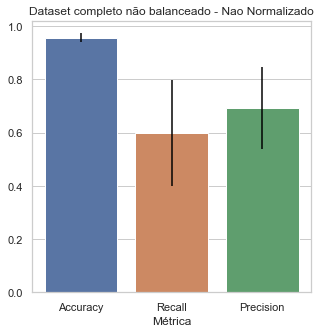

In [22]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_unbalanced, ci = None)
plt.title('Dataset completo não balanceado - Nao Normalizado')


plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('Dataset completo nao balanceado - Nao Normalizado - MLPClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

### Dataset Balanceado

[Text(152.00000000000003, 0.5, '')]

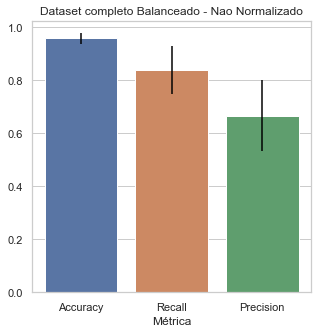

In [23]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_balanced, ci = None)
plt.title('Dataset completo Balanceado - Nao Normalizado')


plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('Dataset completo balanceado - Nao Normalizado - MLPClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [24]:
path_to_save = '../../model_results/'
score_min_unbalanced = pd.DataFrame([acc_min_unbalanced, rec_min_unbalanced, pre_min_unbalanced]).rename(columns = {0: 'Score'})
score_max_unbalanced =  pd.DataFrame([acc_max_unbalanced, rec_max_unbalanced, pre_max_unbalanced]).rename(columns = {0: 'Score'})
score_min_balanced = pd.DataFrame([acc_min_balanced, rec_min_balanced, pre_min_balanced]).rename(columns = {0: 'Score'})
score_max_balanced =  pd.DataFrame([acc_max_balanced, rec_max_balanced, pre_max_balanced]).rename(columns = {0: 'Score'})

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    'MLPClassifier',
    '8',
    'Dataset Completo Desbalanceado - Nao Normalizado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_unbalanced[metrica],score_min_unbalanced.loc[metrica]['Score'], score_max_unbalanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0:'Algoritmo' , 1: 'Atividade', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
for metrica in df_mean_balanced.index:
    result = [
    'MLPClassifier',
    '8',
    'Dataset Completo Balanceado - Nao Normalizado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_balanced[metrica],score_min_balanced.loc[metrica]['Score'], score_max_balanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0:'Algoritmo' , 1: 'Atividade', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

,Algoritmo,Atividade,Condicao,Melhores_Params,Metrica,Valor,Intervalo_Confianca
0,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Accuracy,0.896129,"[0.896, 0.857, 0.935]"
1,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Recall,0.02,"[0.020, -0.025, 0.065]"
2,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Precision,0.00666667,"[0.007, -0.008, 0.022]"
3,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Accuracy,0.690109,"[0.690, 0.473, 0.907]"
4,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Recall,0.216667,"[0.217, -0.049, 0.482]"
5,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Precision,0.0492712,"[0.049, -0.024, 0.123]"
6,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Accuracy,0.822886,"[0.823, 0.784, 0.862]"
7,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Recall,0.153333,"[0.153, 0.034, 0.272]"
8,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Precision,0.0906421,"[0.091, 0.013, 0.169]"
9,Naive Bayes,6,Branch and Bound Balanceado - Normalizado,0.1,Accuracy,0.512845,"[0.513, 0.416, 0.610]"


Resultados salvos com sucesso
